In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

  likely near In[1]:2
  likely near In[1]:2



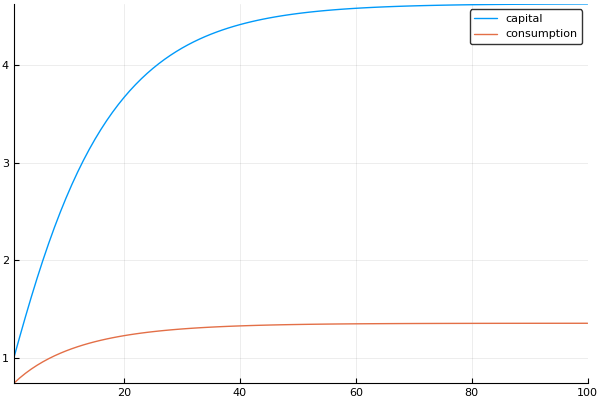

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [127]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [216]:
u_crra_prime(c, γ) = begin
    return c^-γ
end

u_crra_prime_inv(u, γ) = begin
    return u^(-1/γ) 
end

function f(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [234]:
using JuMP
using Ipopt

#m = Model(solver=IpoptSolver(print_level=5, max_iter=500, mu_strategy="adaptive", mu_oracle="probing", tol=1e-12));
#m = Model(solver=IpoptSolver(print_level=5, max_iter=500, mu_strategy="adaptive", mu_oracle="probing", corrector_type="affine"));
m = Model(solver=IpoptSolver(print_level=5, max_iter=600));
#m = Model(solver=IpoptSolver(print_level=5, max_iter=500, mehrotra_algorithm="yes"));

I define the deep parameters variables and give the the correct starting values:

In [235]:
@variable(m, 0 <= β <= 1, start = 0.95)
@variable(m, 0 <= δ <= 1, start = 0.05)
@variable(m, 0 <= α <= 1, start = 0.3)
@variable(m, A >= 0, start = 1)
@variable(m, 100 >= γ >= 1, start = 2);

The policy function is approximated by 10 Chebyshev polynomials on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

I define a grid on capital, $K$, with 10 nodes, and evaluate the Chebyshev polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [236]:
using BasisMatrices
global const params = SplineParams(linspace(0.2*k_stst, 2*k_stst, 10), 0, 3)
basis = Basis(params)
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Ψprime = BasisMatrix(basis, Expanded(), K, 1).vals[1]
#Ψprimeprimeprime = BasisMatrix(basis, Expanded(), K, 3).vals[1]
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1]
Φprime = BasisMatrix(basis, Expanded(), dataK, 1).vals[1];

In [237]:
@variable(m, θ[1:length(K)], start = 0);

And I initialize $\theta$ such that the consumer myopically consumes almost everything available, leaving just $0.5$ capital for the next period:

In [238]:
#initial_θ = Ψ \ (u_crra.((f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 1.), getvalue(γ)) .* 
#    (f_prime(1, getvalue(α), getvalue(A)) + 1-getvalue(δ)))
b2 = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K2 = nodes(b2)[1] #grid
Ψ2 = BasisMatrix(b2, Expanded(), K2).vals[1]
θ2 = Ψ2 \ [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393]


initial_θ = Ψ \ (u_crra_prime.(BasisMatrix(b2, Expanded(), K).vals[1] * θ2, getvalue(γ)) .*
    (f_prime.(f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ)) * K - BasisMatrix(b2, Expanded(), K).vals[1] * θ2, 
        getvalue(α), getvalue(A)) + 1-getvalue(δ)))


for i in 1:length(K)
    setvalue(θ[i], initial_θ[i])
end

In [239]:
u_crra_prime_inv.(Ψ * getvalue(θ), getvalue(γ)) - BasisMatrix(b2, Expanded(), K).vals[1] * θ2
#very good starting point!

12-element Array{Float64,1}:
 -0.0688677
 -0.0639336
 -0.0560414
 -0.0470759
 -0.0400684
 -0.0342355
 -0.0292037
 -0.0247481
 -0.020723 
 -0.0170371
 -0.0147348
 -0.0136244

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [240]:
function interpVprime(x, values...) #x is the point of evaluation, values are on the grid
    return (evalbase(params, [x], 0) * collect(values))[1] #evaluates the first derivative of the basis functions
end

interpVprime (generic function with 1 method)

I register all user-defined functions with JuMP for automatic differentiation:

In [241]:
JuMP.register(m, :interpVprime, 1+length(K), interpVprime, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

The auxiliary and equilibrium constraints are all defined on the grid with 10 nodes:

In [242]:
##EE in consumption:
@NLconstraint(m, increasing[i=1:length(K)], sum(Ψ[i, k] * θ[k] for k in 1:length(K)) >= 0)
@NLconstraint(m, concave[i=1:length(K)], sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) <= 0)

@NLconstraint(m, EE[i=1:length(K)], sum(Ψ[i, k] * θ[k] for k in 1:length(K)) == 
    β * u_crra_prime(u_crra_prime_inv(interpVprime(f(K[i], α, A) + (1-δ)*K[i] - 
            u_crra_prime_inv(sum(Ψ[i, k] * θ[k] for k in 1:length(K)) / (f_prime(K[i], α, A) + 1-δ), γ), 
            θ[1], θ[2], θ[3], θ[4], θ[5], θ[6], θ[7], θ[8], θ[9], θ[10], θ[11], θ[12]) / 
            (f_prime(f(K[i], α, A) + (1-δ)*K[i] - 
            u_crra_prime_inv(sum(Ψ[i, k] * θ[k] for k in 1:length(K)) / (f_prime(K[i], α, A) + 1-δ), γ), α, A) + 1-δ), γ), γ) * (f_prime(f(K[i], α, A) + (1-δ)*K[i] - 
            u_crra_prime_inv(sum(Ψ[i, k] * θ[k] for k in 1:length(K)) / (f_prime(K[i], α, A) + 1-δ), γ), α, A) + 1-δ));

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [243]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
R = f_prime.(dataK, 0.3, 1.) + 1-0.05
@NLexpression(m, predictedC[t=1:100], u_crra_prime_inv(sum(Φ[t, k] * θ[k] for k in 1:length(K)) / R[t], γ));

The objective is to minimize the sum of squared errors:

In [244]:
#+ (β-0.95)^2 + (δ-0.05)^2 + (α-0.3)^2 + (A-1)^2 + (γ-2)^2)
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [245]:
solve(m)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      204
Number of nonzeros in inequality constraint Jacobian.:      288
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       17
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       12
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

:Optimal

In [246]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(1.0, 0.19846049514908845, 0.5308487078533843, 1.0088044915893888, 1.0)


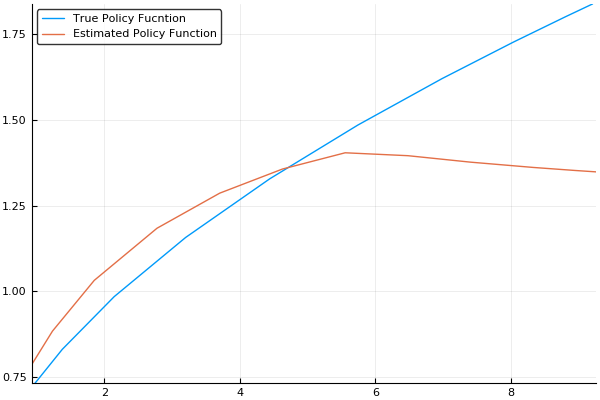

In [247]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, u_crra_prime_inv.((Ψ * getvalue(θ))./(f_prime.(f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 
            u_crra_prime_inv.((Ψ * getvalue(θ)) ./ (f_prime.(K, getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)), getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)), label="Estimated Policy Function")
#plot!(K, getvalue(modelC), label="Estimated Policy Function")


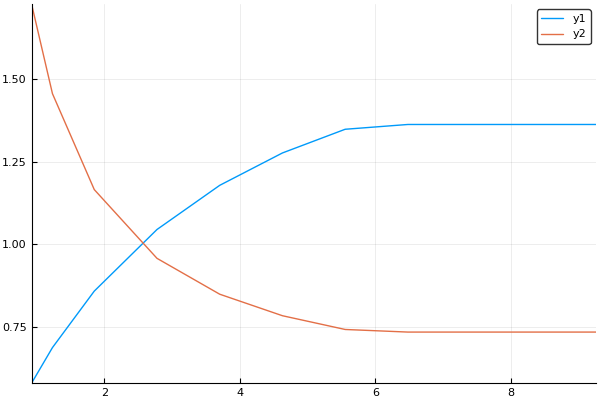

In [248]:
plot(K, u_crra_prime_inv.(Ψ * getvalue(θ), getvalue(γ)))
plot!(K, Ψ * getvalue(θ))

In [249]:
sum(u_crra_prime_inv.(Φprime * getvalue(θ), getvalue(γ)) .< 0)

100

In [250]:
Ψ * getvalue(θ)

12-element Array{Float64,1}:
 1.72924 
 1.45694 
 1.16583 
 0.957189
 0.848343
 0.783064
 0.741338
 0.73344 
 0.73344 
 0.73344 
 0.73344 
 0.73344 

In [251]:
getvalue(modelC)

LoadError: [91mUndefVarError: modelC not defined[39m

In [252]:
getvalue(modelKprime)

LoadError: [91mUndefVarError: modelKprime not defined[39m